# Final Project

## TRAC2- Baseline Models

## Package imports

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization
import tensorflow.keras.backend as K
# for hyperparameter tunning
from keras_tuner import HyperModel
import keras_tuner as kt
# import sklearn to calculate the metrics
from sklearn import metrics

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, label_binarize

from string import ascii_uppercase

In [2]:
print(tf.__version__)

2.6.0


## Load data
Load training, development and test datasets.

In [3]:
# Load aggressiveness dataset
train_data = pd.read_csv('../../data/release-files/eng/trac2_eng_train.csv')
dev_data = pd.read_csv('../../data/release-files/eng/trac2_eng_dev.csv')

# test data data and labels is in separate files, potentially desorganized
test_data = pd.read_csv('../../data/release-files/test/trac2_eng_test.csv')
test_labels_a = pd.read_csv('../../data/release-files/gold/trac2_eng_gold_a.csv')
test_labels_b = pd.read_csv('../../data/release-files/gold/trac2_eng_gold_b.csv')

## Helper functions

In [4]:
def from_prob_to_labels(model, x, task):
    '''
    Returns labels based on predicted probability on labels [CAG,NAG,OAG] for task A. Task B is binary, and 'GEN' represents 
    the positive class.
    Parameters:
    model: trained model
    x: input data
    task: either 'A' or 'B'
    '''
    pred = model.predict(x)
    
    index_a = {0:'CAG', 1:'NAG', 2:'OAG'}
    
    if task == 'A':
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_a.get)(highest_prob_class.astype(int))
        
    elif task == 'B':
        labels = np.where(pred <0.5, 'NGEN', 'GEN')
    else:
        labels = []
        
    return labels    

In [5]:
def to_binary_labels(string_labels, classes_list):
    '''
    Returns an array with 0 and 1 for a binary classification problem.
    Parameters:
    string_labels: array with 2 categories defined as strings e.g. ['cat', 'dog', 'dog', ...] 
    classes_list: array with the two classes. The order of the array defines which gets 0 and which gets 1. The first
                  gets 0.
    '''

    labels = label_binarize(string_labels, classes = classes_list).flatten()
    
    return labels 

In [6]:
def to_one_hot_labels(string_labels):
    '''
    Returns one-hot encoded labels from a multi-class label vector e.g. ['cat', 'dog', 'dog', 'lion', 'cat', ...] 
    Parameters:
    string_labels: 
    '''
    labels = pd.get_dummies(string_labels)
    labels = labels.to_numpy()
    
    return labels

In [7]:
def confusion_matrix_plot(model, input_data, true_labels, task, normalize=None):
    '''
    Returns a confusion matrix with a nice format.
    Parameters:
    model: trained model
    input data: data we want to use to evaluate the model
    true_labels: true labels 
    task: 'A' or 'B'
    normalize: if want to normalize the confusion matrix normalize='true'
    '''
    
    # get predicted labels
    pred_labels = from_prob_to_labels(model, input_data, task)
    
    # Create a confusion matrix
    cm = metrics.confusion_matrix(true_labels, pred_labels, normalize=normalize)
    cm = np.around(cm, 2)

    # Plot the confusion matrix
    if task == 'A':
        axis_labels = ['CAG', 'NAG', 'OAG']
    elif task == 'B':
        axis_labels = ['GEN', 'NGEN']

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")

    # Create the ticks and labels
    ax.set_xticks(np.arange(len(axis_labels)))
    ax.set_yticks(np.arange(len(axis_labels)))
    ax.set_xticklabels(axis_labels)
    ax.set_yticklabels(axis_labels)

    # Axis titles
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

    # Loop over data dimensions and create text annotations.
    for i in range(len(axis_labels)):
        for j in range(len(axis_labels)):
            text = ax.text(j, i, cm[i, j],ha="center", va="center", color="dimgrey", size=12)
    
    ax.set_title("Confusion Matrix", size=16, weight="bold")
    fig.tight_layout()
    plt.show()


## Baseline model for aggression identification (sub task A)

### Baseline: Neural Bag of Words Model

Our baseline model is a bag of words model...

In [8]:
# create arrays of text examples for train, development and test data
train_text = np.array(train_data['Text'])
dev_text = np.array(dev_data['Text'])
test_text = np.array(test_data['Text'])

In [9]:
# create arrays of labels for train, development and test data
train_labels = np.array(train_data['Sub-task A'])
dev_labels = np.array(dev_data['Sub-task A'])
test_labels = np.array(test_labels_a['Sub-task A'])

In [10]:
# load pre-trained word embeddings. In this case Glove
# This is commented out to avoid downloading it again
# !wget http://nlp.stanford.edu/data/glove.6B.zip -P ~/data/

In [11]:
# unzip the file
# commented out for the same reason above
# !unzip ~/data/glove.6B.zip -d ~/data/

In [12]:
# path to glove file- will use the embeddings with dimension = 300
glove_file ="../../data/glove.6B.300d.txt"

In [13]:
# encode the labels (one-hot encode them) as keras requires
# [CAG,NAG,OAG]
train_labels_enc = to_one_hot_labels(train_labels)
train_labels_enc

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [14]:
# encode the labels for the development and test datasets
dev_labels_enc = to_one_hot_labels(dev_labels)
test_labels_enc = to_one_hot_labels(test_labels)

In [15]:
# create a vocabulary index 
# consider this maximum number of words- Played with larger vocab sizes, but 10,000 is enough.
max_tokens = 10000
# truncate or pad sequences to be this long
max_sequence_lenght = 100

vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_sequence_lenght)

2021-09-19 18:34:02.084399: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
# train vocabulary
vectorizer.adapt(train_text)

# save vocabulary in a variable
vocab = vectorizer.get_vocabulary()

2021-09-19 18:34:02.138629: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [17]:
print(f'Vocabulary has {len(vocab)} words.')

Vocabulary has 10000 words.


In [18]:
# inspect the vocabulary first words
vocab[:10]

['', '[UNK]', 'the', 'and', 'is', 'to', 'a', 'of', 'i', 'you']

In [19]:
# see how it works with a test sentence
# 0 is reserved for padding and index 1 is reserved for out of vocabulary tokens
example_sentence = 'Of all the places to travel, Spain is at the top of my list.'
vectorizer(example_sentence)

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([   7,   35,    2, 2175,    5,    1,    1,    4,   88,    2,  480,
          7,   54,  921,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])>

In [20]:
# create an index for each word {word: index}
word_idx = dict(zip(vocab, range(len(vocab))))

In [21]:
# Map words with their vector representation (embeddings)
embeddings_glove = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_glove[word] = coefs

print(f'Number of embeddings available: {len(embeddings_glove)}')

Number of embeddings available: 400000


In [22]:
# just to check let's get the dimensions of one of the embeddings
embeddings_glove['home'].shape

(300,)

In [23]:
# build embedding matrix to use it in the model
dimensions_emb = 300
total_tokens = len(vocab) + 2
with_embedding = []
without_embedding = []

# initialize embedding matrix with zeroes
embedding_matrix = np.zeros((total_tokens, dimensions_emb))

for word, index in word_idx.items():
    emb_vector = embeddings_glove.get(word)
    # add to matrix
    # count converted and not converted words
    if emb_vector is not None:
        embedding_matrix[index] = emb_vector
        with_embedding.append(word)
    else:
        without_embedding.append(word)

print(f'Number of words with embeddings found: {len(with_embedding)}')
print(f'Number of words with embeddings NOT found: {len(without_embedding)}')

Number of words with embeddings found: 6928
Number of words with embeddings NOT found: 3072


In [24]:
# Let's explore the words with no embedding available in glove
# Most of them are typos, some emoticons, numbers, Chinese characters?
without_embedding[:100]

['',
 '[UNK]',
 'shwetabh',
 'chutiya',
 '😂',
 'don’t',
 '498a',
 'it’s',
 '👍',
 '👌',
 '😍',
 '😂😂',
 'borade',
 'i’m',
 '🙏',
 '😂😂😂😂',
 '😂😂😂',
 'tshirt',
 '🔥',
 'arundati',
 '🤣',
 '💯',
 '🤣🤣🤣',
 '😊',
 'vedio',
 'shahids',
 'mensutra',
 'kutiya',
 'can’t',
 'arundathi',
 '😂😂😂😂😂',
 '😁',
 '👍👍',
 'that’s',
 'ryt',
 'plzz',
 'antinational',
 'yess',
 'pubg',
 'misandrists',
 'didn’t',
 'bcz',
 'bcoz',
 'arundhuti',
 '09777070288',
 '🤣🤣',
 '🙌',
 '😅',
 '👍👍👍',
 '👌👌',
 'theyll',
 'swetabh',
 'supar',
 'madarchod',
 'feminazi',
 'charecter',
 'bhakts',
 '🤔',
 '🙏🙏',
 '😠',
 '😘',
 '👏👏',
 '👍👍👍👍',
 '👌👌👌',
 '❤️',
 '❤',
 'wassepur',
 'viswambharan',
 'vaun',
 'thouta',
 'thik',
 'soch',
 'shouldnt',
 'selfdestructive',
 'potray',
 'moviei',
 'movi',
 'lallantop',
 'kapoors',
 'kabirs',
 'hlo',
 'hahaha',
 'doesn’t',
 'becoz',
 'bakwas',
 'achyuth',
 'achhi',
 '7045495339',
 '🙏🏻🙏🏻',
 '😎',
 '😈',
 '😂🤣',
 '😀😀',
 '👎',
 '✌',
 '♥️',
 'नहीं',
 'videoi',
 'vedios',
 'vaiya']

In [25]:
# does glove recognize some emoticons? No
a_smile = '😁'
a_smile in without_embedding

True

In [26]:
# what about teh most basic smile? No
a_smile2 = '😊'
a_smile in without_embedding

True

In [27]:
# prepare input data for the model
# convert the train sentences to sequences of ids
train_input = vectorizer(train_text)

In [28]:
# check the dimensions
# looks good 10125 examples and 100 max lenght
train_input.shape

TensorShape([4263, 100])

In [29]:
# Let's get one of the training examples
train_text[0]

'Next part'

In [30]:
# this is the representation of this training example with the index of the words and padding
train_input[0]

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([489, 317,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])>

In [31]:
# do the same for development and test data
dev_input = vectorizer(dev_text)
test_input = vectorizer(test_text)

In [32]:
# delete model if exists
try:
    del BOW_model
except:
    pass

In [33]:
# Define the model

# create embedding layer
# input_lenght: Keras' embedding layer expects a specific input length. Padding is needed here. The vectorizer
# defined above takes care of the padding
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_lenght,
                            trainable=False)

# simple sequential model
BOW_model = tf.keras.Sequential()
# include the embedding layer
BOW_model.add(embedding_layer)
# average embedding vectors
BOW_model.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
# hidden layer with rectified linear activation function (relu)
BOW_model.add(Dense(100, activation='relu'))  
# dropout layer for regularization
BOW_model.add(Dropout(0.2))
# output layer with 3 classes classification
BOW_model.add(Dense(3, activation='softmax'))

In [34]:
# compile the model
# categorical_crossentropy: loss function appropiate for multi-class single label classification
BOW_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.categorical_accuracy])

In [35]:
# summary of the model's architecture
BOW_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          3000600   
_________________________________________________________________
lambda (Lambda)              (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 3,031,003
Trainable params: 30,403
Non-trainable params: 3,000,600
_________________________________________________________________


In [36]:
# train the model and store the training history
training_history = BOW_model.fit(train_input, 
                                 train_labels_enc, 
                                 validation_data=(dev_input, dev_labels_enc),
                                 epochs=50, 
                                 verbose=0)

Text(0.5, 1.0, 'Training and validation loss- Sub-task A')

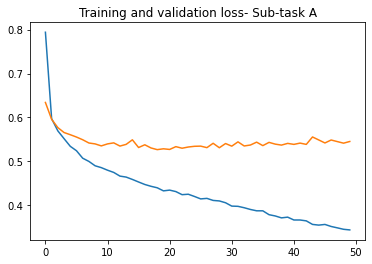

In [37]:
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Training and validation loss- Sub-task A')

Text(0.5, 1.0, 'Training and validation acccuracy- Sub-task A')

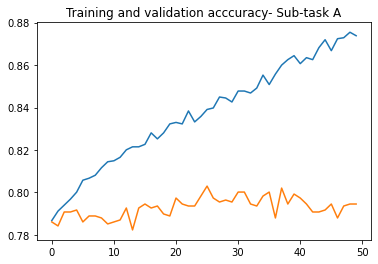

In [38]:
plt.plot(training_history.history['categorical_accuracy'])
plt.plot(training_history.history['val_categorical_accuracy'])
plt.title('Training and validation acccuracy- Sub-task A')

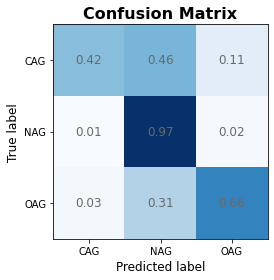

              precision    recall  f1-score   support

         CAG      0.800     0.424     0.554       453
         NAG      0.905     0.973     0.938      3375
         OAG      0.725     0.660     0.691       435

    accuracy                          0.882      4263
   macro avg      0.810     0.685     0.728      4263
weighted avg      0.876     0.882     0.872      4263

Weighted f1-score: 0.8717635607429429


In [39]:
# Evaluate model on TRAINING data

# predict labels using the training data
pred_labels_train = from_prob_to_labels(BOW_model, train_input, 'A')

# Create the confusion matrix
confusion_matrix_plot(BOW_model, train_input, train_labels, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels, pred_labels_train, pos_label=1, average='weighted')}")

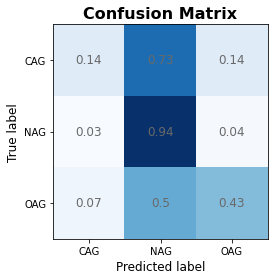

              precision    recall  f1-score   support

         CAG      0.333     0.137     0.194       117
         NAG      0.847     0.935     0.889       836
         OAG      0.516     0.434     0.471       113

    accuracy                          0.795      1066
   macro avg      0.565     0.502     0.518      1066
weighted avg      0.756     0.795     0.769      1066

Weighted f1-score: 0.768530615334149


In [40]:
# Evaluate model on DEVELOPMENT data

# predict labels using the development data
pred_labels_dev = from_prob_to_labels(BOW_model, dev_input, 'A')

# Create confusion matrix
confusion_matrix_plot(BOW_model, dev_input, dev_labels, task='A', normalize='true')

# Print the precision, recall, f1
print(metrics.classification_report(dev_labels, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels, pred_labels_dev, pos_label=1, average='weighted')}")

#### Hyperparamters selection using random search

In [41]:
# first we need to define a hypermodel using a model builder function
# same model architecture we used earlier

def model_builder(hp):
    
    # sequential model
    model = tf.keras.Sequential()
        
    # embedding layer
    model.add(Embedding(embedding_matrix.shape[0],
                        embedding_matrix.shape[1],
                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                        input_length=max_sequence_lenght,
                        trainable=False))
        
    # average embedding vectors
    model.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
        
    # hidden layer
    hp_units = hp.Int('units', min_value=20, max_value=150, step=10)
    model.add(Dense(units=hp_units, activation='relu'))

    # dropout layer 
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.4, default=0.0, step=0.05)
    model.add(Dropout(dropout))
        
    # output layer 
    model.add(Dense(3, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_crossentropy'])
    
    return model

In [42]:
# remove folder if exists to avoid error
!rm -r ./hp_search_baseline_task_A

rm: cannot remove './hp_search_baseline_task_A': No such file or directory


In [43]:
tuner = kt.RandomSearch(model_builder, objective='categorical_crossentropy', max_trials=10, directory='hp_search_baseline_task_A')

In [44]:
tuner.search(train_input, train_labels_enc, validation_data=(dev_input, dev_labels_enc), epochs=50, verbose=0)

INFO:tensorflow:Oracle triggered exit


In [45]:
# Best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
# Reinstantiate the (untrained) best model found during the search process.
BOW_model_optimized = tuner.hypermodel.build(best_hp)

In [46]:
print(f"The optimal number of units in the hidden layer is {best_hp.get('units')} and the optimal dropout is {best_hp.get('dropout')}.")

The optimal number of units in the hidden layer is 100 and the optimal dropout is 0.15000000000000002.


In [47]:
training_history = BOW_model_optimized.fit(train_input, 
                                           train_labels_enc,
                                           validation_data=(dev_input, dev_labels_enc),
                                           epochs=50, verbose=0
                                          )

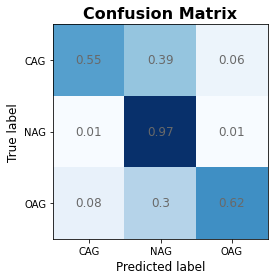

              precision    recall  f1-score   support

         CAG      0.743     0.550     0.632       453
         NAG      0.915     0.971     0.942      3375
         OAG      0.780     0.621     0.691       435

    accuracy                          0.890      4263
   macro avg      0.813     0.714     0.755      4263
weighted avg      0.883     0.890     0.884      4263

Weighted f1-score: 0.883544574256489


In [48]:
# Evaluate model on TRAINING data

# predict labels using the training data
pred_labels_train = from_prob_to_labels(BOW_model_optimized, train_input, 'A')

# Create confusion matrix
confusion_matrix_plot(BOW_model_optimized, train_input, train_labels, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels, pred_labels_train, pos_label=1, average='weighted')}")

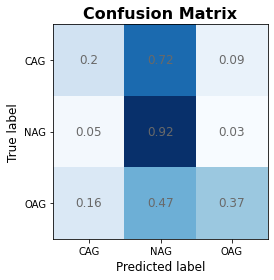

              precision    recall  f1-score   support

         CAG      0.277     0.197     0.230       117
         NAG      0.849     0.921     0.884       836
         OAG      0.553     0.372     0.444       113

    accuracy                          0.783      1066
   macro avg      0.560     0.496     0.519      1066
weighted avg      0.755     0.783     0.765      1066

Weighted f1-score: 0.7652596251171037


In [49]:
# Evaluate model on DEVELOPMENT data

# predict labels using the development data
pred_labels_dev = from_prob_to_labels(BOW_model_optimized, dev_input, 'A')

# Create confusion matrix
confusion_matrix_plot(BOW_model_optimized, dev_input, dev_labels, task='A', normalize='true')

# Print the precision, recall, f1
print(metrics.classification_report(dev_labels, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels, pred_labels_dev, pos_label=1, average='weighted')}")

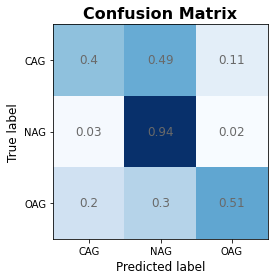

              precision    recall  f1-score   support

         CAG      0.529     0.402     0.457       224
         NAG      0.770     0.942     0.847       690
         OAG      0.780     0.507     0.614       286

    accuracy                          0.738      1200
   macro avg      0.693     0.617     0.640      1200
weighted avg      0.727     0.738     0.719      1200

Weighted f1-score: 0.7190009392296883


In [50]:
# Now we can evaluate the optimized model on the TEST data.

# predict labels using the development data
pred_labels_test = from_prob_to_labels(BOW_model_optimized, test_input, 'A')

# Create confusion matrix
confusion_matrix_plot(BOW_model_optimized, test_input, test_labels, task='A', normalize='true')

# Print the precision, recall, f1
print(metrics.classification_report(test_labels, pred_labels_test, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels, pred_labels_test, pos_label=1, average='weighted')}")

## Baseline model for gendered aggression identification (sub task B)


### Baseline: Neural Bag of Words Model

Our baseline model is a bag of words model...

In [51]:
# create arrays of labels for train, development and test data
train_labels_b = np.array(train_data['Sub-task B'])
dev_labels_b = np.array(dev_data['Sub-task B'])
test_labels_b = np.array(test_labels_b['Sub-task B'])

In [52]:
# encode the labels. As this is a binary classification we use binary labels 0:NGEN, 1:GEN
train_labels_enc_b = to_binary_labels(train_labels_b, classes_list=['NGEN', 'GEN'])
train_labels_enc_b

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
# encode the labels for the development and test datasets (0:NGEN, 1:GEN)
dev_labels_enc_b = to_binary_labels(dev_labels_b, classes_list=['NGEN', 'GEN'])
test_labels_enc_b = to_binary_labels(test_labels_b, classes_list=['NGEN', 'GEN'])

In [54]:
# delete model if exists
try:
    del BOW_model_B
except:
    pass

In [55]:
# Define the model

# create embedding layer
# input_lenght: Keras' embedding layer expects a specific input length. Padding is needed here. The vectorizer
# defined above takes care of the padding
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_lenght,
                            trainable=False)

# simple sequential model
BOW_model_B = tf.keras.Sequential()
# include the embedding layer
BOW_model_B.add(embedding_layer)
# average embedding vectors
BOW_model_B.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
# hidden layer with rectified linear activation function (relu)
BOW_model_B.add(Dense(100, activation='relu'))  
# dropout layer for regularization
BOW_model_B.add(Dropout(0.2))
# output layer with binary classification
BOW_model_B.add(Dense(1, activation='sigmoid'))

In [56]:
# compile the model
# categorical_crossentropy: loss function appropiate for multi-class single label classification
BOW_model_B.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.categorical_accuracy])


In [57]:
BOW_model_B.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3000600   
_________________________________________________________________
lambda_1 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,030,801
Trainable params: 30,201
Non-trainable params: 3,000,600
_________________________________________________________________


In [58]:
# train the model and store the training history
training_history = BOW_model_B.fit(train_input, 
                                 train_labels_enc_b, 
                                 validation_data=(dev_input, dev_labels_enc_b),
                                 epochs=50, 
                                 verbose=0)

Text(0.5, 1.0, 'Training and validation loss- Sub-task B')

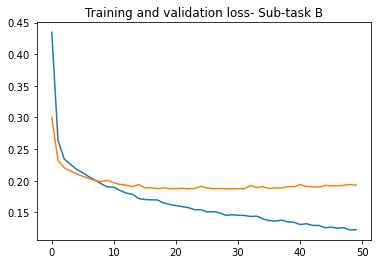

In [59]:
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Training and validation loss- Sub-task B')

Text(0.5, 1.0, 'Training and validation acccuracy- Sub-task B')

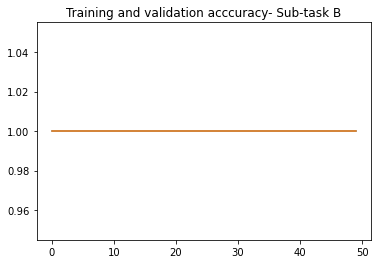

In [60]:
plt.plot(training_history.history['categorical_accuracy'])
plt.plot(training_history.history['val_categorical_accuracy'])
plt.title('Training and validation acccuracy- Sub-task B')

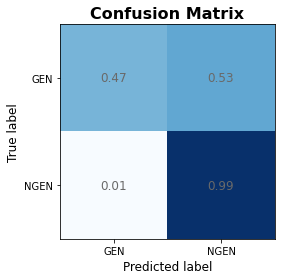

              precision    recall  f1-score   support

         GEN      0.880     0.472     0.615       309
        NGEN      0.960     0.995     0.977      3954

    accuracy                          0.957      4263
   macro avg      0.920     0.734     0.796      4263
weighted avg      0.954     0.957     0.951      4263

Weighted f1-score: 0.9509919976656831


In [61]:
# Evaluate model on TRAINING data

# predict labels using the training data
pred_labels_train_b = from_prob_to_labels(BOW_model_B, train_input, 'B')

# Create confusion matrix
confusion_matrix_plot(BOW_model_B, train_input, train_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_b, pred_labels_train_b, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_b, pred_labels_train_b, pos_label=1, average='weighted')}")

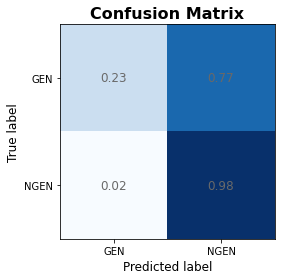

              precision    recall  f1-score   support

         GEN      0.486     0.233     0.315        73
        NGEN      0.946     0.982     0.963       993

    accuracy                          0.931      1066
   macro avg      0.716     0.607     0.639      1066
weighted avg      0.914     0.931     0.919      1066

Weighted f1-score: 0.9190207744025347


In [62]:
# Evaluate model on DEVELOPMENT data

# predict labels using the training data
pred_labels_dev_b = from_prob_to_labels(BOW_model_B, dev_input, 'B')

# Create confusion matrix
confusion_matrix_plot(BOW_model_B, dev_input, dev_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_b, pred_labels_dev_b, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_b, pred_labels_dev_b, pos_label=1, average='weighted')}")

#### Hyperparamters selection using random search

In [63]:
# first we need to define a hypermodel using a model builder function
# same model architecture we used earlier

def model_builder_b(hp):
    
    # sequential model
    model = tf.keras.Sequential()
        
    # embedding layer
    model.add(Embedding(embedding_matrix.shape[0],
                        embedding_matrix.shape[1],
                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                        input_length=max_sequence_lenght,
                        trainable=False))
        
    # average embedding vectors
    model.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
        
    # hidden layer
    hp_units = hp.Int('units', min_value=20, max_value=150, step=10)
    model.add(Dense(units=hp_units, activation='relu'))

    # dropout layer 
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.4, default=0.0, step=0.05)
    model.add(Dropout(dropout))
        
    # output layer 
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_crossentropy'])
    
    return model

In [64]:
# remove folder if exists to avoid error
!rm -r ./hp_search_baseline_task_B

rm: cannot remove './hp_search_baseline_task_B': No such file or directory


In [65]:
tuner_b = kt.RandomSearch(model_builder_b, objective='categorical_crossentropy', max_trials=10, directory='hp_search_baseline_task_B')

In [66]:
tuner_b.search(train_input, train_labels_enc_b, validation_data=(dev_input, dev_labels_enc_b), epochs=50, verbose=0)

INFO:tensorflow:Oracle triggered exit


In [67]:
# Best hyperparameters
best_hp_b = tuner_b.get_best_hyperparameters()[0]
# Reinstantiate the (untrained) best model found during the search process.
BOW_model_B_optimized = tuner_b.hypermodel.build(best_hp_b)

In [68]:
print(f"The optimal number of units in the hidden layer is {best_hp_b.get('units')} and the optimal dropout is {best_hp_b.get('dropout')}.")

The optimal number of units in the hidden layer is 120 and the optimal dropout is 0.15000000000000002.


In [69]:
training_history = BOW_model_B_optimized.fit(train_input, 
                                             train_labels_enc_b,
                                             validation_data=(dev_input, dev_labels_enc_b),
                                             epochs=50, verbose=0
                                            )

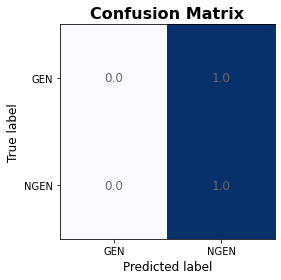

              precision    recall  f1-score   support

         GEN      0.000     0.000     0.000       309
        NGEN      0.928     1.000     0.962      3954

    accuracy                          0.928      4263
   macro avg      0.464     0.500     0.481      4263
weighted avg      0.860     0.928     0.893      4263

Weighted f1-score: 0.8926366331553583


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
# Evaluate model on TRAINING data

# predict labels using the training data
pred_labels_train_b = from_prob_to_labels(BOW_model_B_optimized, train_input, 'B')

# create confusion matrix
confusion_matrix_plot(BOW_model_B_optimized, train_input, train_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_b, pred_labels_train_b, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_b, pred_labels_train_b, pos_label=1, average='weighted')}")

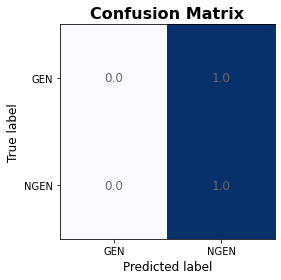

              precision    recall  f1-score   support

         GEN      0.000     0.000     0.000        73
        NGEN      0.932     1.000     0.965       993

    accuracy                          0.932      1066
   macro avg      0.466     0.500     0.482      1066
weighted avg      0.868     0.932     0.898      1066

Weighted f1-score: 0.8984935035587139


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
# Evaluate model on DEVELOPMENT data

# predict labels using the training data
pred_labels_dev_b = from_prob_to_labels(BOW_model_B_optimized, dev_input, 'B')

# Create confusion matrix
confusion_matrix_plot(BOW_model_B_optimized, dev_input, dev_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_b, pred_labels_dev_b, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_b, pred_labels_dev_b, pos_label=1, average='weighted')}")

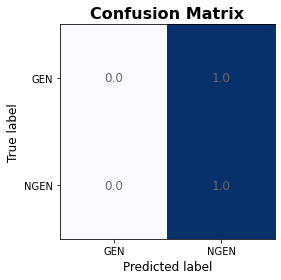

              precision    recall  f1-score   support

         GEN      0.000     0.000     0.000       175
        NGEN      0.854     1.000     0.921      1025

    accuracy                          0.854      1200
   macro avg      0.427     0.500     0.461      1200
weighted avg      0.730     0.854     0.787      1200

Weighted f1-score: 0.7869850187265918


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
# Now we can evaluate the optimized model on the TEST data.

# predict labels using the training data
pred_labels_test_b = from_prob_to_labels(BOW_model_B_optimized, test_input, 'B')

# Create confusion matrix
confusion_matrix_plot(BOW_model_B_optimized, test_input, test_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_b, pred_labels_test_b, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_b, pred_labels_test_b, pos_label=1, average='weighted')}")

The hyperparameters search is not giving better results. The optimized model is predicting all examples as NGEN. This is because the data is very imbalanced (almost all examples are NGEN). Because of this, we will use as baseline the model before the optimization process.

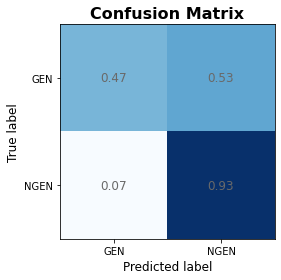

              precision    recall  f1-score   support

         GEN      0.532     0.474     0.502       175
        NGEN      0.912     0.929     0.920      1025

    accuracy                          0.863      1200
   macro avg      0.722     0.702     0.711      1200
weighted avg      0.856     0.863     0.859      1200

Weighted f1-score: 0.8591849690219161


In [73]:
# Now we can evaluate the optimized model on the TEST data.

# predict labels using the training data
pred_labels_test_b = from_prob_to_labels(BOW_model_B, test_input, 'B')

# Create confusion matrix
confusion_matrix_plot(BOW_model_B, test_input, test_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_b, pred_labels_test_b, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_b, pred_labels_test_b, pos_label=1, average='weighted')}")

## Housekeeping
Save models and delete hyper-parameter search folders. 


In [74]:
# save model when we are ready
BOW_model_optimized.save('./TRAC-2_saved_models/Baseline_task_A')
BOW_model_B.save('./TRAC-2_saved_models/Baseline_task_B')

2021-09-19 18:48:10.044671: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./TRAC-2_saved_models/Baseline_task_A/assets
INFO:tensorflow:Assets written to: ./TRAC-2_saved_models/Baseline_task_B/assets


In [77]:
# remove hyper-parameter search directory
!rm -r ./hp_search_baseline_task_A
!rm -r ./hp_search_baseline_task_B

In [76]:
# to load models back
# baseline_task_A = tf.keras.models.load_model('./TRAC-2_saved_models/Baseline_task_A')
# baseline_task_B = tf.keras.models.load_model('./TRAC-2_saved_models/Baseline_task_B')

## References

- Using pre-trained word embeddings: https://keras.io/examples/nlp/pretrained_word_embeddings/

- Keras random search: https://keras.io/api/keras_tuner/tuners/random/#randomsearch-class
